In [1]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

In [2]:
# importing data
headers = ['Movie', 'Genre', 'Description']
train_df = pd.read_csv('dataset/train_data.txt', delimiter=':::', engine='python', names=headers)

In [3]:
# visualizing the dataframe
train_df.head()

,Movie,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
# get df info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Movie        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [5]:
# number of films per genre
train_df['Genre'].value_counts()

Genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

In [47]:
train_df['Genre'].unique()

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [6]:
len(train_df['Genre'].unique())

27

In [7]:
sns.set_theme(style='whitegrid')

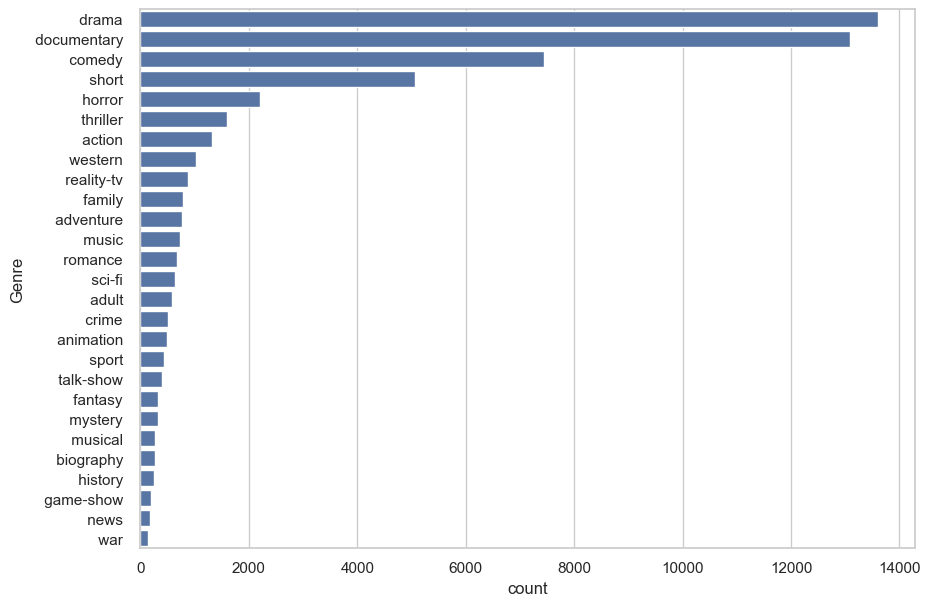

In [8]:
plt.figure(figsize=(10, 7))
sns.countplot(train_df['Genre'], order=train_df['Genre'].value_counts().index)
plt.show()

### Pre-processing 

In [9]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).strip()

In [10]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return " ".join(filtered_text)

In [11]:
# testing both functions
text = "The striped bats are hanging on their feet for best"
text = remove_stopwords(text)
remove_punctuation(text)

'The striped bats hanging feet best'

In [12]:
def stemming(text):
    snowball = SnowballStemmer(language='english')
    list=[]
    for token in word_tokenize(text):
        list.append(snowball.stem(token))
    return ' '.join(list)

In [16]:
from nltk.stem import WordNetLemmatizer

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    word_list = word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

    return lemmatized_output

In [17]:
text = "The striped bats are hanging on their feet for best"
print(stemming(text))
print(lemmatizing(text))

the stripe bat are hang on their feet for best
The striped bat are hanging on their foot for best


In [18]:
def preprocess_data(text):
    text = text.casefold()

    # remove hyperlinks, email addresses, and non-characters
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'.pic\S+', '', text)
    text = re.sub(r'[^a-zA-Z+]', ' ', text)

    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatizing(text)
    return text

In [19]:
# verifying the method
text = train_df['Description'].iloc[0]
result = preprocess_data(text)

print(text)
print("Processed: ", result)

 Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.
Processed:  listening conversation doctor parent year old oscar learns nobody courage tell week live furious refuse speak anyone except straight talking rose lady pink meet hospital stair christmas approach rose us fantastical experience professional wrestler imagination wit charm allow oscar live life love full company friend pop corn einstein bacon childhood sweetheart peggy blue


In [20]:
train_df['Processed_Description'] = train_df['Description'].apply(preprocess_data)

In [21]:
# visualing dataframe after the operation
train_df.head()

,Movie,Genre,Description,Processed_Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parent year old ...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empty student field trip museum natural hi...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make end meet edith twi...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers un recovered body ground zer...


In [68]:
from sklearn.feature_extraction.text import CountVectorizer

def get_most_used_words(df, genre):
    vectorizer = CountVectorizer()

    local_df = df[df['Genre'].str.strip() == genre]['Processed_Description']
    
    x = vectorizer.fit_transform(local_df.values)

    word_counts = x.sum(axis=0)

    # Convert matrix to a DataFrame
    words_df = pd.DataFrame(word_counts, columns=vectorizer.get_feature_names_out())

    # Transpose the DataFrame and reset the index
    words_df = words_df.T.reset_index()

    # Rename the columns
    words_df.columns = ['Word', 'Count']

    # Sort the DataFrame by count and print the top 10 words
    top_words = words_df.sort_values(by='Count', ascending=False).head(10)

    plt.figure(figsize=(10, 7))
    plt.title(f'Most common words for the {genre} genre')
    sns.barplot(x='Word', y='Count', data=top_words)
    plt.show()

After preprocessing the text, we look at the most common words used in the description of a few genres

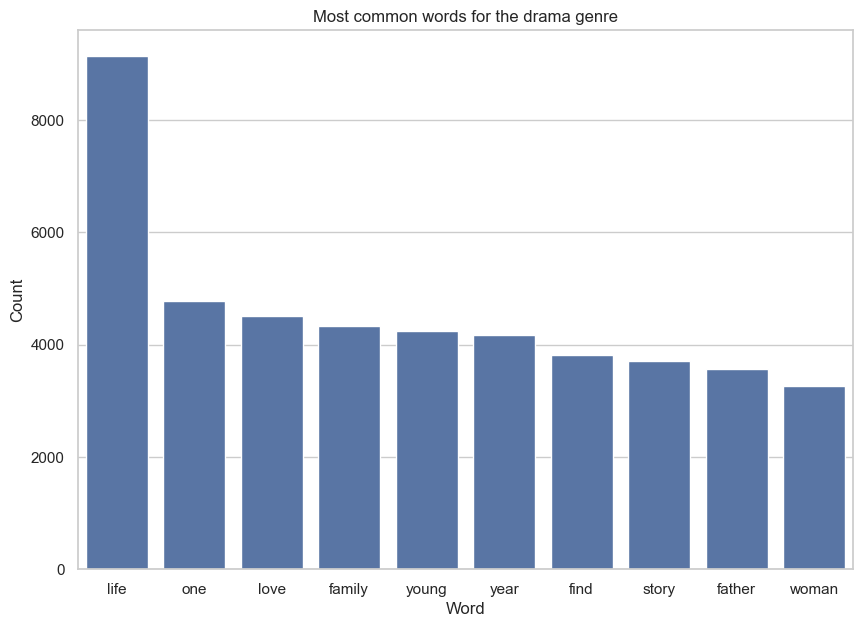

In [69]:
get_most_used_words(train_df, 'drama')

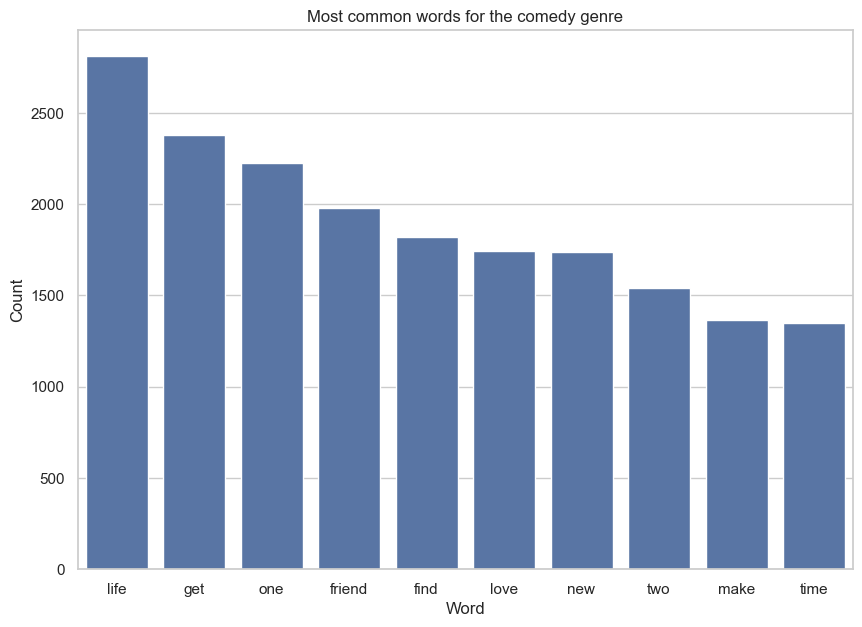

In [70]:
get_most_used_words(train_df, 'comedy')

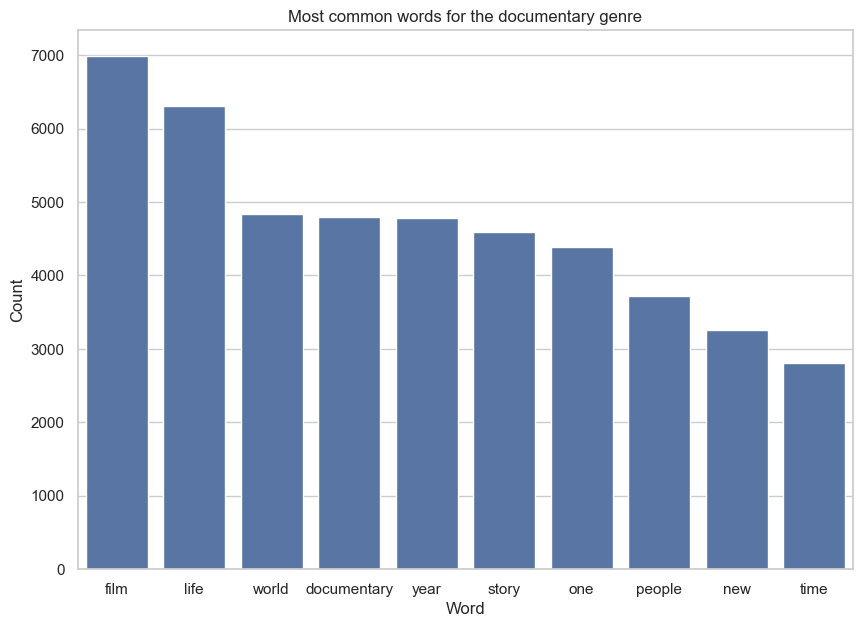

In [71]:
get_most_used_words(train_df, 'documentary')

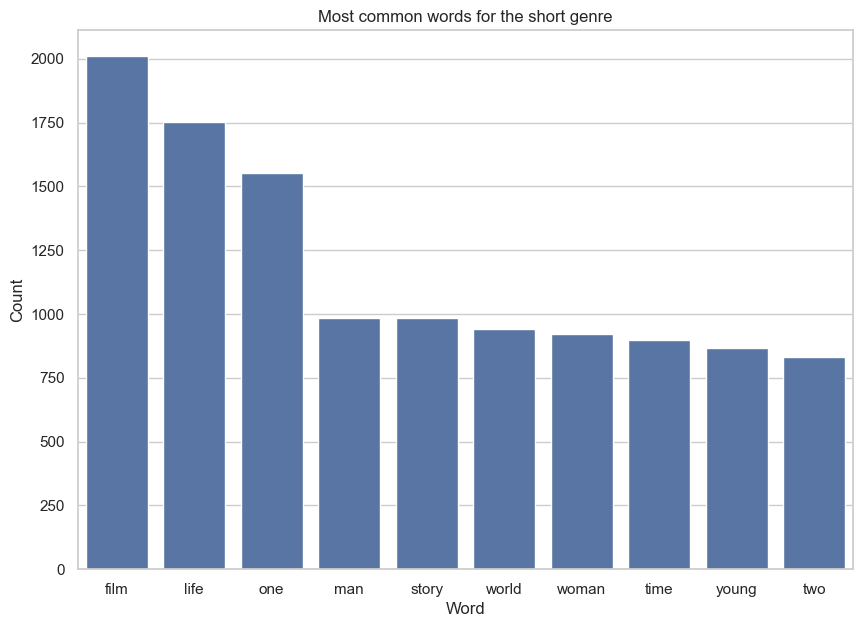

In [72]:
get_most_used_words(train_df, 'short')

Each graph shows that the descriptions of the 4 most popular genres share several similar words: *life, woman, man, film, one*

In [22]:
# splitting input an ouput vectors
X = train_df.drop(['Movie', 'Genre'], axis=1)
y = train_df['Genre']

In [23]:
# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train.head()

,Description,Processed_Description
19254,Sex. Betrayal. Seduction. Manipulation. Addic...,sex betrayal seduction manipulation addiction ...
12262,"Autistic teen, Tony and his friendship with C...",autistic teen tony friendship cameron boy stil...
37144,"The one-hour special examines this socially, ...",one hour special examines socially ethnically ...
21966,This personal narrative documentary uses my b...,personal narrative documentary us bicycle ride...
7034,The easy-going village policeman Artturi Saka...,easy going village policeman artturi sakari re...


### 1.0 TF-IDF approach

In [25]:
vectorizer = TfidfVectorizer(analyzer='word')
X_train_vectorized = vectorizer.fit_transform(X_train['Processed_Description'])
X_test_vectorized = vectorizer.transform(X_test['Processed_Description'])

In [26]:
print(X_test_vectorized.shape)
print(y_test.shape)

(10843, 95326)
(10843,)


#### 1.1 SGD Classifier

In [27]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier()
sgd_model.fit(X_train_vectorized, y_train)

SGDClassifier()

In [28]:
# performance in the training test
sgd_model.score(X_train_vectorized, y_train)

0.7470890687325632

In [29]:
y_pred = sgd_model.predict(X_test_vectorized)

print("Precision:", precision_score(y_test, y_pred, average='micro'))
print("Recall:", recall_score(y_test, y_pred, average='micro'))
print("F1 Score:", f1_score(y_test, y_pred, average='micro'))

Precision: 0.57235082541732
Recall: 0.57235082541732
F1 Score: 0.57235082541732


In [73]:
# Define the parameter values that should be searched
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
              'max_iter': [1000], # number of epochs
              'loss': ['log_loss', 'perceptron', 'modified_huber', 'squared_hinge', 'hinge'],
              'penalty': ['l2'],
              'n_jobs': [-1]}

# Create a GridSearchCV object and fit it to the training data
sgd = SGDClassifier()
grid_search = GridSearchCV(sgd, param_grid, cv=5)
grid_search.fit(X_train_vectorized, y_train)

# Print the best parameters found by the grid search
print(grid_search.best_params_)

{'alpha': 0.0001, 'loss': 'modified_huber', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}


In [74]:
grid_search.best_estimator_.score(X_train_vectorized, y_train)

0.8445735629798713

In [75]:
y_pred = grid_search.best_estimator_.predict(X_test_vectorized)

print("Precision:", precision_score(y_test, y_pred, average='micro'))
print("Recall:", recall_score(y_test, y_pred, average='micro'))
print("F1 Score:", f1_score(y_test, y_pred, average='micro'))

Precision: 0.5943926957484091
Recall: 0.5943926957484091
F1 Score: 0.5943926957484091


#### 1.2 Naive Bayes

In [30]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [31]:
nb_model.score(X_train_vectorized, y_train)

0.4673168707200664

In [32]:
y_pred = nb_model.predict(X_test_vectorized)

print("Precision:", precision_score(y_test, y_pred, average='micro'))
print("Recall:", recall_score(y_test, y_pred, average='micro'))
print("F1 Score:", f1_score(y_test, y_pred, average='micro'))

Precision: 0.44378861938577885
Recall: 0.44378861938577885
F1 Score: 0.44378861938577885


The performance of the Naive Bayes Classifier is worse than random guessing; therefore, it is not worth further investigation

#### 1.3 Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=50)
forest_model.fit(X_train_vectorized, y_train)

RandomForestClassifier(n_estimators=50)

In [34]:
forest_model.score(X_train_vectorized, y_train)

0.9996541467801066

In [35]:
y_pred = forest_model.predict(X_test_vectorized)

print("Precision:", precision_score(y_test, y_pred, average='micro'))
print("Recall:", recall_score(y_test, y_pred, average='micro'))
print("F1 Score:", f1_score(y_test, y_pred, average='micro'))

Precision: 0.48021765194134464
Recall: 0.48021765194134464
F1 Score: 0.48021765194134464


The models performed poorly with clear indications of overfitting in some cases. The words used in each film description are not sufficient to distinguish between them with high accuracy

### 2.0 Word Embeddings Approach